# Data Drift Analyzer Example

## Imports

In [1]:
import polars as pl
import polars.selectors as cs
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from datetime import datetime, timedelta
from polars.exceptions import ComputeError, NoDataError
import gc
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional, List
from dataclasses import dataclass
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Optional
import gc


## Utility functions

In [2]:

# @dataclass
# class DriftParameters:
#     """Data class for drift parameters with validation"""
#     length_mean: float
#     length_std: float
#     width_mean: float
#     width_std: float
#     density_shape: float
#     density_scale: float
#     class_a_prob: float
#     class_b_prob: float
#     defect_prob: float

#     def __post_init__(self):
#         """Validate parameters after initialization"""
#         if self.length_std <= 0 or self.width_std <= 0:
#             raise ValueError("Standard deviations must be positive")
#         if self.density_shape <= 0 or self.density_scale <= 0:
#             raise ValueError("Gamma parameters must be positive")
#         if not 0 <= self.class_a_prob <= 1 or not 0 <= self.class_b_prob <= 1:
#             raise ValueError("Probabilities must be between 0 and 1")
#         if self.class_a_prob + self.class_b_prob > 1:
#             raise ValueError("Sum of class probabilities must be <= 1")
#         if not 0 <= self.defect_prob <= 1:
#             raise ValueError("Defect probability must be between 0 and 1") 
        

def generate_sample_data(size: int = 1000, drift_params: Optional[Dict] = None) -> pl.DataFrame:
    """Generate smaller sample data with controlled memory usage"""
    if drift_params is None:
        drift_params = {
            'length_mean': 5.8,
            'length_std': 0.8,
            'width_mean': 3.0,
            'width_std': 0.4,
            'density_shape': 2.0,
            'density_scale': 0.8,
            'class_a_prob': 0.33,
            'class_b_prob': 0.33,
            'defect_prob': 0.05
        }
    
    np.random.seed(42)
    
    # Generate data in chunks to manage memory
    chunk_size = min(1000, size)
    dfs = []
    
    for chunk_start in range(0, size, chunk_size):
        chunk_size_actual = min(chunk_size, size - chunk_start)
        
        # Generate numeric features
        length = np.random.normal(
            drift_params['length_mean'],
            drift_params['length_std'],
            chunk_size_actual
        )
        
        width = np.random.normal(
            drift_params['width_mean'],
            drift_params['width_std'],
            chunk_size_actual
        )
        
        density = np.random.gamma(
            drift_params['density_shape'],
            drift_params['density_scale'],
            chunk_size_actual
        )
        
        # Generate categorical features with controlled cardinality
        classes = np.random.choice(
            ['Class_A', 'Class_B', 'Class_C'],
            chunk_size_actual,
            p=[drift_params['class_a_prob'], 
               drift_params['class_b_prob'],
               1 - drift_params['class_a_prob'] - drift_params['class_b_prob']]
        )
        
        # Limit number of categories
        subtypes = np.random.choice(
            ['Type_1', 'Type_2', 'Type_3'],
            chunk_size_actual,
            p=[0.4, 0.3, 0.3]
        )
        
        # Boolean features
        has_defect = np.random.choice(
            [True, False],
            chunk_size_actual,
            p=[drift_params['defect_prob'], 1 - drift_params['defect_prob']]
        )
        
        # Generate some nulls (controlled amount)
        null_mask = np.random.choice(
            [True, False],
            chunk_size_actual,
            p=[0.02, 0.98]  # Reduced null percentage
        )
        length[null_mask] = np.nan
        
        # Generate IDs
        sample_ids = np.arange(chunk_start, chunk_start + chunk_size_actual)
        batch_ids = np.random.randint(1, 11, chunk_size_actual)  # Reduced number of batches
        
        # Create chunk DataFrame
        chunk_df = pl.DataFrame({
            'sample_id': sample_ids,
            'batch_id': batch_ids,
            'length': length,
            'width': width,
            'density': density,
            'class': classes,
            'subtype': subtypes,
            'has_defect': has_defect
        })
        
        dfs.append(chunk_df)
        
        # Clear some memory
        del length, width, density, classes, subtypes, has_defect
        gc.collect()
    
    # Combine chunks
    result = pl.concat(dfs)
    del dfs
    gc.collect()
    
    return result

def run_example(sample_size: int = 1000):
    """Run the example with proper cleanup"""
    try:
        # Close any existing plots
        plt.close('all')
        
        print("Generating training data...")
        train_data = generate_sample_data(sample_size)
        
        print("Generating inference data...")
        inference_params = {
            'length_mean': 6.2,
            'length_std': 1.0,
            'width_mean': 2.8,
            'width_std': 0.5,
            'density_shape': 1.8,
            'density_scale': 0.9,
            'class_a_prob': 0.40,
            'class_b_prob': 0.35,
            'defect_prob': 0.08
        }
        
        inference_data = generate_sample_data(sample_size, inference_params)
        
        # Add simple drift patterns
        print("Adding drift patterns...")
        inference_data = inference_data.with_columns([
            pl.when(pl.col('subtype') == 'Type_3')
            .then(pl.lit('Type_4'))
            .otherwise(pl.col('subtype'))
            .alias('subtype')
        ])
        
        print("Initializing analyzer...")
        analyzer = DataDriftAnalyzer(
            train_df=train_data,
            inf_df=inference_data,
            join_keys=['batch_id'],
            exclude_cols=[]
        )
        
        print("Running analysis...")
        joined_results, overall_results = analyzer.analyze_drift()
        
        print("\n=== Training Data Sample ===")
        print(train_data.head())
        print("\n=== Inference Data Sample ===")
        print(inference_data.head())
        print("\n=== Data Drift Analysis ===")
        analyzer.print_drift_summary(joined_results, "Joined")
        
        # Cleanup
        plt.close('all')
        del train_data, inference_data
        gc.collect()
        
    except Exception as e:
        print(f"Error in example: {str(e)}")
        plt.close('all')
        gc.collect()
        raise

## Class

In [3]:
class DataDriftAnalyzer:
    def __init__(
        self,
        train_df: pl.DataFrame,
        inf_df: pl.DataFrame,
        join_keys: List[str],
        exclude_cols: List[str],
    ):
        """
        Initialize the Data Drift Analyzer

        Parameters:
        -----------
        train_df : pl.DataFrame
            Training dataset
        inf_df : pl.DataFrame
            Inference dataset
        join_keys : List[str]
            Columns to join datasets on for like-to-like comparison
        exclude_cols : List[str]
            Columns to exclude from analysis
        """
        self.train_df = train_df
        self.inf_df = inf_df
        self.join_keys = join_keys
        self.exclude_cols = exclude_cols

        # Get common columns excluding join keys and excluded columns
        self.common_cols = [
            col
            for col in train_df.columns
            if col in inf_df.columns
            and col not in join_keys
            and col not in exclude_cols
        ]

        # Identify numeric columns using polars selectors
        self.numeric_cols = [
            col
            for col in self.common_cols
            if col in train_df.select(cs.numeric()).columns
        ]

        # Remaining columns are categorical
        self.categorical_cols = [
            col for col in self.common_cols if col not in self.numeric_cols
        ]

        print(
            f"Analyzing {len(self.numeric_cols)} numeric columns: {self.numeric_cols}"
        )
        print(
            f"Analyzing {len(self.categorical_cols)} categorical columns: {self.categorical_cols}"
        )

    def get_numeric_stats(self, df: pl.DataFrame, cols: List[str]) -> Dict:
        """Get summary statistics for numeric columns using Polars expressions"""
        stats_exprs = []
        for col in cols:
            stats_exprs.extend(
                [
                    pl.col(col).mean().alias(f"{col}_mean"),
                    pl.col(col).std().alias(f"{col}_std"),
                    pl.col(col).min().alias(f"{col}_min"),
                    pl.col(col).max().alias(f"{col}_max"),
                ]
            )

        return df.select(stats_exprs).to_dict(as_series=False)

    def analyze_distributions(
        self, data1: pl.DataFrame, data2: pl.DataFrame, col: str
    ) -> Dict:
        """Analyze distributions for a single column"""
        if col in self.numeric_cols:
            # Numeric analysis remains the same
            data1_array = data1[col].drop_nulls().to_numpy()
            data2_array = data2[col].drop_nulls().to_numpy()

            ks_stat, p_value = stats.ks_2samp(data1_array, data2_array)

            stats1 = data1.select(
                [
                    pl.col(col).mean().alias("mean"),
                    pl.col(col).std().alias("std"),
                    pl.col(col).min().alias("min"),
                    pl.col(col).max().alias("max"),
                ]
            ).to_dict(as_series=False)

            stats2 = data2.select(
                [
                    pl.col(col).mean().alias("mean"),
                    pl.col(col).std().alias("std"),
                    pl.col(col).min().alias("min"),
                    pl.col(col).max().alias("max"),
                ]
            ).to_dict(as_series=False)

            result = {
                "column": col,
                "type": "numeric",
                "ks_statistic": ks_stat,
                "p_value": p_value,
                "mean_diff": float(stats1["mean"][0] - stats2["mean"][0]),
                "std_diff": float(stats1["std"][0] - stats2["std"][0]),
                "data1_stats": {
                    "mean": float(stats1["mean"][0]),
                    "std": float(stats1["std"][0]),
                    "min": float(stats1["min"][0]),
                    "max": float(stats1["max"][0]),
                },
                "data2_stats": {
                    "mean": float(stats2["mean"][0]),
                    "std": float(stats2["std"][0]),
                    "min": float(stats2["min"][0]),
                    "max": float(stats2["max"][0]),
                },
            }
        else:
            # For categorical columns
            val_counts1 = (
                data1.select(pl.col(col))
                .group_by(col)
                .agg(pl.len().alias("counts"))
                .sort("counts", descending=True)
            )

            val_counts2 = (
                data2.select(pl.col(col))
                .group_by(col)
                .agg(pl.len().alias("counts"))
                .sort("counts", descending=True)
            )

            # Get categories that appear in both datasets
            common_categories = set(val_counts1[col].to_list()) & set(
                val_counts2[col].to_list()
            )

            # If we have no common categories, we can't perform chi-square test
            if not common_categories:
                chi2_stat = np.inf  # Indicating maximum difference
                p_value = 0.0  # Indicating significant difference
                contingency_warning = "No common categories found between datasets"
            else:
                # Filter for common categories only
                counts1 = [
                    val_counts1.filter(pl.col(col) == cat)["counts"].item()
                    if len(val_counts1.filter(pl.col(col) == cat)) > 0
                    else 0
                    for cat in common_categories
                ]
                counts2 = [
                    val_counts2.filter(pl.col(col) == cat)["counts"].item()
                    if len(val_counts2.filter(pl.col(col) == cat)) > 0
                    else 0
                    for cat in common_categories
                ]

                # Ensure we have valid counts for chi-square test
                if sum(counts1) > 0 and sum(counts2) > 0:
                    try:
                        chi2_stat, p_value = stats.chi2_contingency([counts1, counts2])[
                            :2
                        ]
                        contingency_warning = None
                    except ValueError as e:
                        chi2_stat = np.inf
                        p_value = 0.0
                        contingency_warning = f"Chi-square test failed: {str(e)}"
                else:
                    chi2_stat = np.inf
                    p_value = 0.0
                    contingency_warning = "Insufficient data for chi-square test"

            # Get unique categories in each dataset
            unique_cats1 = set(val_counts1[col].to_list())
            unique_cats2 = set(val_counts2[col].to_list())

            result = {
                "column": col,
                "type": "categorical",
                "chi2_statistic": float(chi2_stat),
                "p_value": float(p_value),
                "unique_values_diff": len(unique_cats1) - len(unique_cats2),
                "categories_only_in_train": list(unique_cats1 - unique_cats2),
                "categories_only_in_inference": list(unique_cats2 - unique_cats1),
                "common_categories": list(common_categories),
                "data1_top_categories": val_counts1.head(5).to_dict(as_series=False),
                "data2_top_categories": val_counts2.head(5).to_dict(as_series=False),
            }

            if contingency_warning:
                result["warning"] = contingency_warning

        return result

    def print_drift_summary(self, results: Dict, analysis_type: str = ""):
        """Print a summary of the drift analysis results"""
        print(f"\n{analysis_type} Analysis Summary")
        print("=" * 80)
        print(
            f"Sample sizes: Training: {results['sample_sizes']['training']}, "
            f"Inference: {results['sample_sizes']['inference']}"
        )
        print("\nSignificant Distribution Changes:")

        for col, analysis in results["column_analysis"].items():
            if analysis["type"] == "numeric":
                if analysis["p_value"] < 0.05:
                    print(f"\n{col} (Numeric):")
                    print(f"  - KS test p-value: {analysis['p_value']:.4f}")
                    print(f"  - Mean difference: {analysis['mean_diff']:.4f}")
                    print(f"  - Std difference: {analysis['std_diff']:.4f}")
            else:
                if analysis["p_value"] < 0.05:
                    print(f"\n{col} (Categorical):")
                    print(f"  - Chi-square test p-value: {analysis['p_value']:.4f}")
                    print(
                        f"  - Unique values difference: {analysis['unique_values_diff']}"
                    )
                    if analysis.get("warning"):
                        print(f"  - Warning: {analysis['warning']}")
                    if analysis["categories_only_in_train"]:
                        print(
                            f"  - Categories only in training: {analysis['categories_only_in_train']}"
                        )
                    if analysis["categories_only_in_inference"]:
                        print(
                            f"  - Categories only in inference: {analysis['categories_only_in_inference']}"
                        )

    def plot_distribution_comparison(
        self, data1: pl.DataFrame, data2: pl.DataFrame, col: str, title_prefix: str = ""
    ):
        """Plot distribution comparison for a single column"""
        plt.figure(figsize=(12, 6))

        if col in self.numeric_cols:
            # For numeric columns
            data1_array = data1[col].drop_nulls().to_numpy()
            data2_array = data2[col].drop_nulls().to_numpy()

            if len(data1_array) > 0 and len(data2_array) > 0:
                # Check variances
                var1 = np.var(data1_array)
                var2 = np.var(data2_array)

                if var1 == 0 and var2 == 0:
                    # Both distributions have no variance - use bar plot
                    values = np.unique([data1_array[0], data2_array[0]])
                    plt.bar([0], [len(data1_array)], width=0.35, label="Training")
                    plt.bar([0], [len(data2_array)], width=0.35, label="Inference")
                    plt.xticks([0], [f"{values[0]:.2f}"])
                    plt.title(f"{title_prefix}{col} - Constant Value Distribution")
                    plt.ylabel("Count")

                elif var1 == 0 or var2 == 0:
                    # One distribution has no variance - use histogram
                    bins = max(
                        10, min(50, int(np.sqrt(len(data1_array) + len(data2_array))))
                    )

                    if var1 == 0:
                        constant_val = data1_array[0]
                        plt.axvline(
                            x=constant_val,
                            color="blue",
                            linestyle="-",
                            label=f"Training (constant={constant_val:.2f})",
                        )
                        plt.hist(
                            data2_array,
                            bins=bins,
                            alpha=0.5,
                            density=True,
                            label="Inference",
                            color="orange",
                        )
                    else:
                        constant_val = data2_array[0]
                        plt.hist(
                            data1_array,
                            bins=bins,
                            alpha=0.5,
                            density=True,
                            label="Training",
                            color="blue",
                        )
                        plt.axvline(
                            x=constant_val,
                            color="orange",
                            linestyle="-",
                            label=f"Inference (constant={constant_val:.2f})",
                        )

                    plt.title(
                        f"{title_prefix}Distribution Comparison - {col}\n(One constant distribution)"
                    )

                else:
                    # Both distributions have variance - use KDE with fallback
                    try:
                        # Try KDE first
                        sns.kdeplot(
                            data=data1_array,
                            label="Training",
                            alpha=0.5,
                            warn_singular=False,
                        )
                        sns.kdeplot(
                            data=data2_array,
                            label="Inference",
                            alpha=0.5,
                            warn_singular=False,
                        )
                    except (ValueError, RuntimeError):
                        # Fallback to histogram if KDE fails
                        bins = max(
                            10,
                            min(50, int(np.sqrt(len(data1_array) + len(data2_array)))),
                        )
                        plt.hist(
                            data1_array,
                            bins=bins,
                            alpha=0.5,
                            density=True,
                            label="Training",
                            color="blue",
                        )
                        plt.hist(
                            data2_array,
                            bins=bins,
                            alpha=0.5,
                            density=True,
                            label="Inference",
                            color="orange",
                        )

                    plt.title(f"{title_prefix}Distribution Comparison - {col}")

                plt.xlabel(col)

                # Add summary statistics to the plot
                stats_text = (
                    f"Training: mean={np.mean(data1_array):.2f}, std={np.std(data1_array):.2f}\n"
                    f"Inference: mean={np.mean(data2_array):.2f}, std={np.std(data2_array):.2f}"
                )
                plt.annotate(
                    stats_text,
                    xy=(0.02, 0.98),
                    xycoords="axes fraction",
                    verticalalignment="top",
                    bbox=dict(boxstyle="round", facecolor="white", alpha=0.8),
                )

            else:
                plt.text(
                    0.5,
                    0.5,
                    "Insufficient data for distribution plot\n(too many null values)",
                    ha="center",
                    va="center",
                )
                plt.title(f"{title_prefix}Distribution Comparison - {col} (No Data)")
        else:
            # Categorical plotting code remains the same
            val_counts1 = (
                data1.select(pl.col(col))
                .group_by(col)
                .agg(pl.len().alias("counts"))
                .sort("counts", descending=True)
                .head(10)
            )

            val_counts2 = (
                data2.select(pl.col(col))
                .group_by(col)
                .agg(pl.len().alias("counts"))
                .sort("counts", descending=True)
                .head(10)
            )

            # Get all unique categories from both datasets
            all_categories = set(val_counts1[col].to_list()) | set(
                val_counts2[col].to_list()
            )
            all_categories = sorted(list(all_categories))[
                :10
            ]  # Limit to top 10 categories

            if len(all_categories) > 0:
                counts1 = []
                counts2 = []
                categories = []

                for category in all_categories:
                    categories.append(str(category))
                    count1 = val_counts1.filter(pl.col(col) == category)[
                        "counts"
                    ].to_list()
                    counts1.append(count1[0] if count1 else 0)
                    count2 = val_counts2.filter(pl.col(col) == category)[
                        "counts"
                    ].to_list()
                    counts2.append(count2[0] if count2 else 0)

                x = np.arange(len(categories))
                width = 0.35

                plt.bar(x - width / 2, counts1, width, label="Training")
                plt.bar(x + width / 2, counts2, width, label="Inference")

                plt.xticks(x, categories, rotation=45, ha="right")
                plt.title(f"{title_prefix}Top Categories Comparison - {col}")
                plt.xlabel("Categories")
                plt.ylabel("Count")
            else:
                plt.text(
                    0.5, 0.5, "No categorical data available", ha="center", va="center"
                )
                plt.title(f"{title_prefix}Category Comparison - {col} (No Data)")

        plt.legend()
        plt.tight_layout()
        plt.show()

    def analyze_drift(self) -> Tuple[Dict, Dict]:
        """
        Analyze data drift between training and inference datasets
        Returns analysis results for both joined and overall comparisons
        """
        # Joined analysis using Polars join
        joined_train = self.train_df
        joined_inf = self.inf_df

        try:
            joined_train = joined_train.join(
                joined_inf.select(self.join_keys), on=self.join_keys, how="inner"
            )

            joined_inf = joined_inf.join(
                joined_train.select(self.join_keys), on=self.join_keys, how="inner"
            )

            joined_results = {
                "sample_sizes": {
                    "training": len(joined_train),
                    "inference": len(joined_inf),
                },
                "column_analysis": {},
            }

            # Overall analysis (without joining)
            overall_results = {
                "sample_sizes": {
                    "training": len(self.train_df),
                    "inference": len(self.inf_df),
                },
                "column_analysis": {},
            }

            # Analyze each column
            for col in self.common_cols:
                try:
                    # Joined analysis
                    joined_results["column_analysis"][col] = self.analyze_distributions(
                        joined_train, joined_inf, col
                    )
                    self.plot_distribution_comparison(
                        joined_train, joined_inf, col, title_prefix="Joined Data: "
                    )

                    # Overall analysis
                    overall_results["column_analysis"][
                        col
                    ] = self.analyze_distributions(self.train_df, self.inf_df, col)
                    self.plot_distribution_comparison(
                        self.train_df, self.inf_df, col, title_prefix="Overall Data: "
                    )
                except Exception as e:
                    print(f"Warning: Error analyzing column {col}: {str(e)}")
                    continue

            return joined_results, overall_results

        except Exception as e:
            print(f"Error in analyze_drift: {str(e)}")
            return {
                "sample_sizes": {"training": 0, "inference": 0},
                "column_analysis": {},
                "error": str(e),
            }, {
                "sample_sizes": {"training": 0, "inference": 0},
                "column_analysis": {},
                "error": str(e),
            }


## Main

Generating training data...
Generating inference data...
Adding drift patterns...
Initializing analyzer...
Analyzing 4 numeric columns: ['sample_id', 'length', 'width', 'density']
Analyzing 3 categorical columns: ['class', 'subtype', 'has_defect']
Running analysis...


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


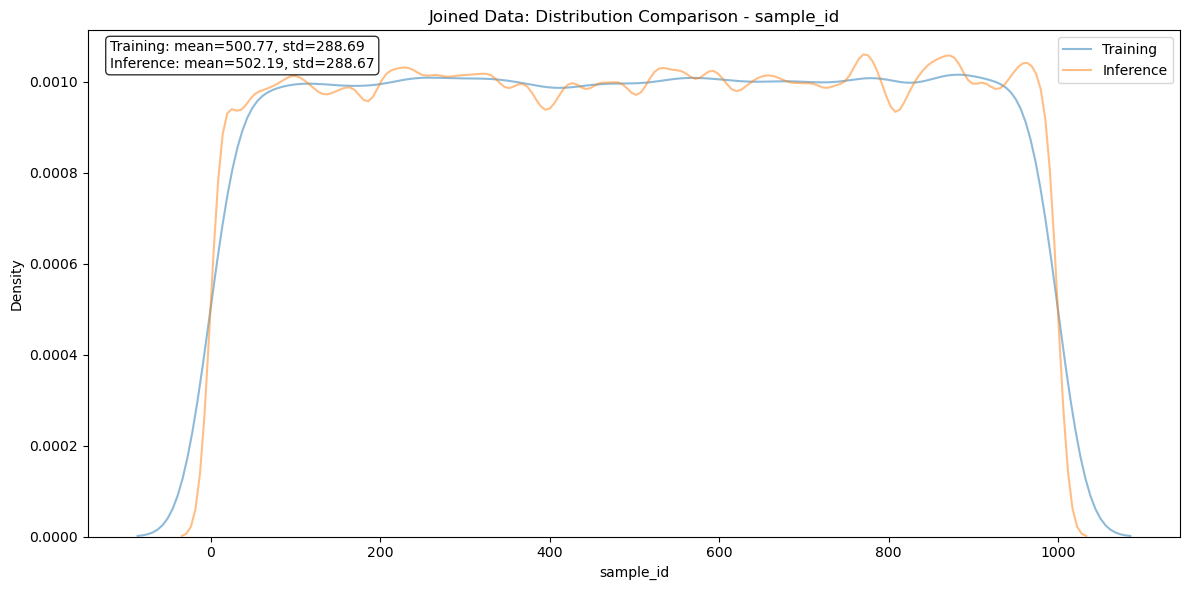

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


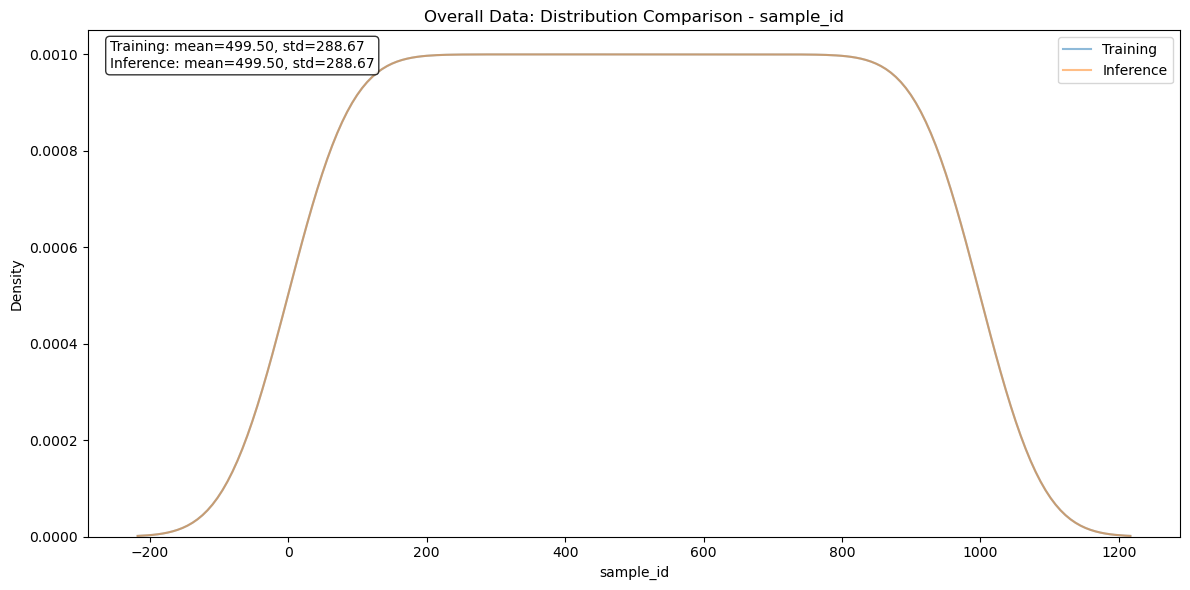

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


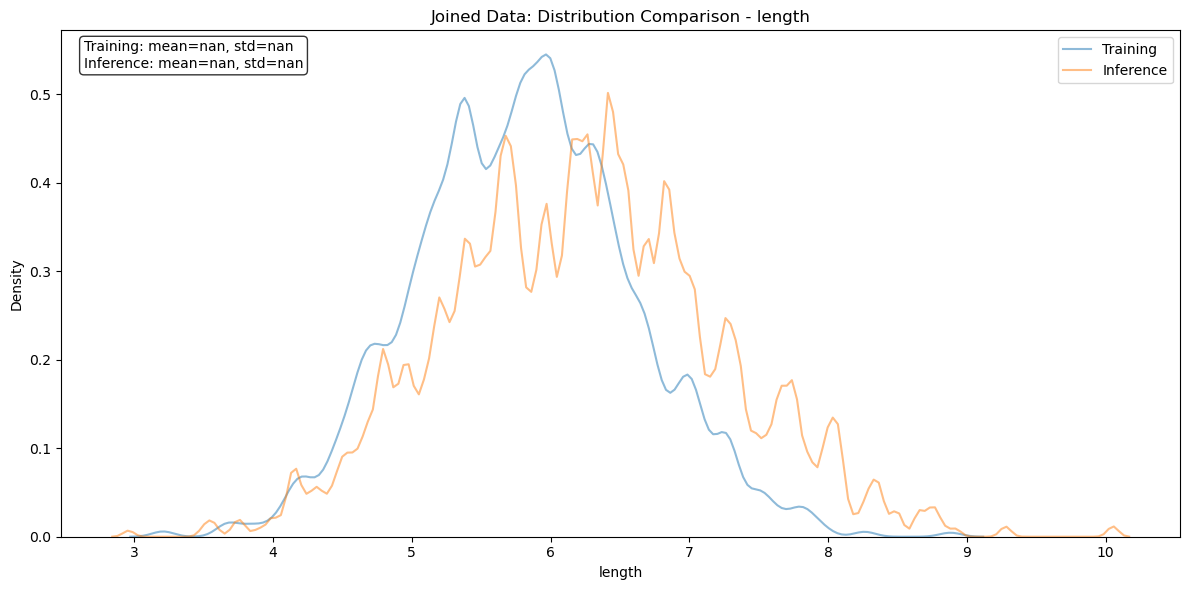

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


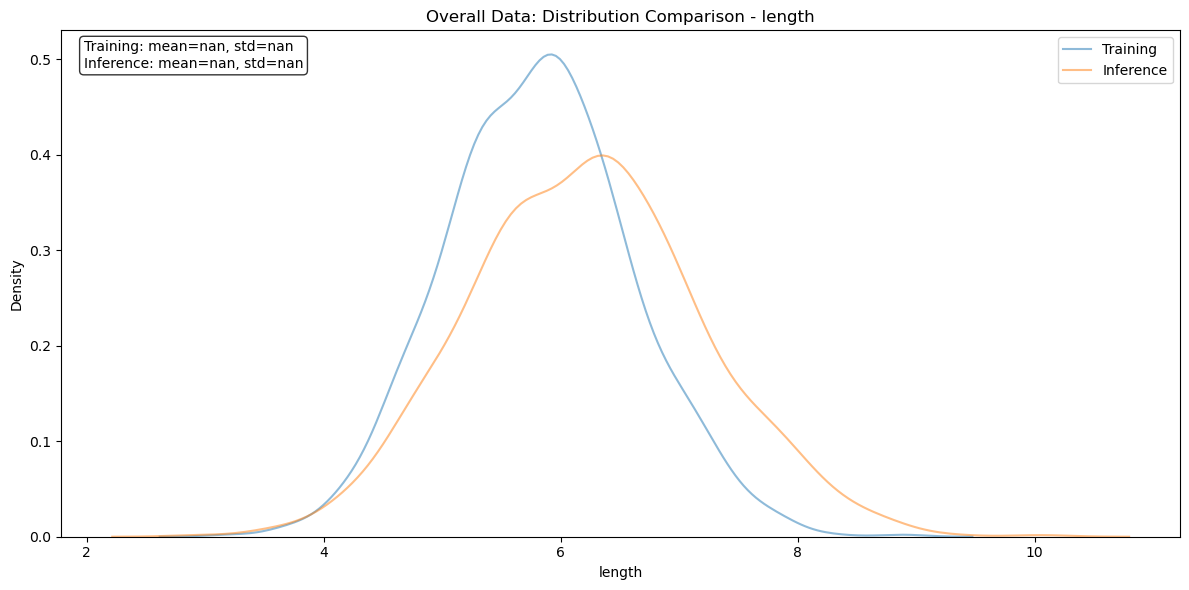

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


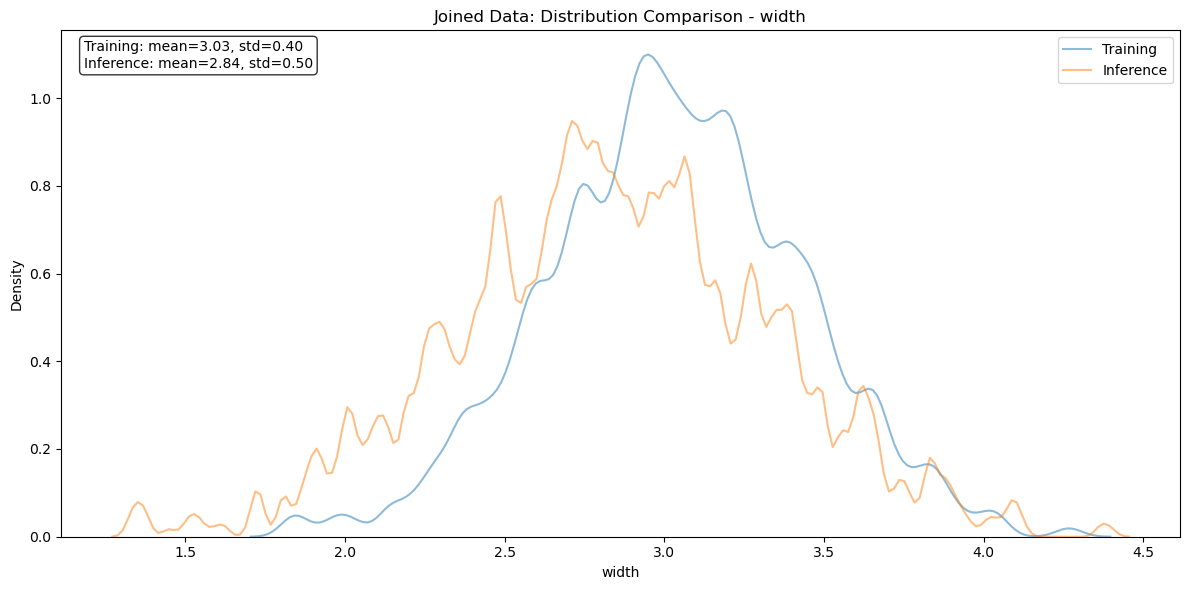

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


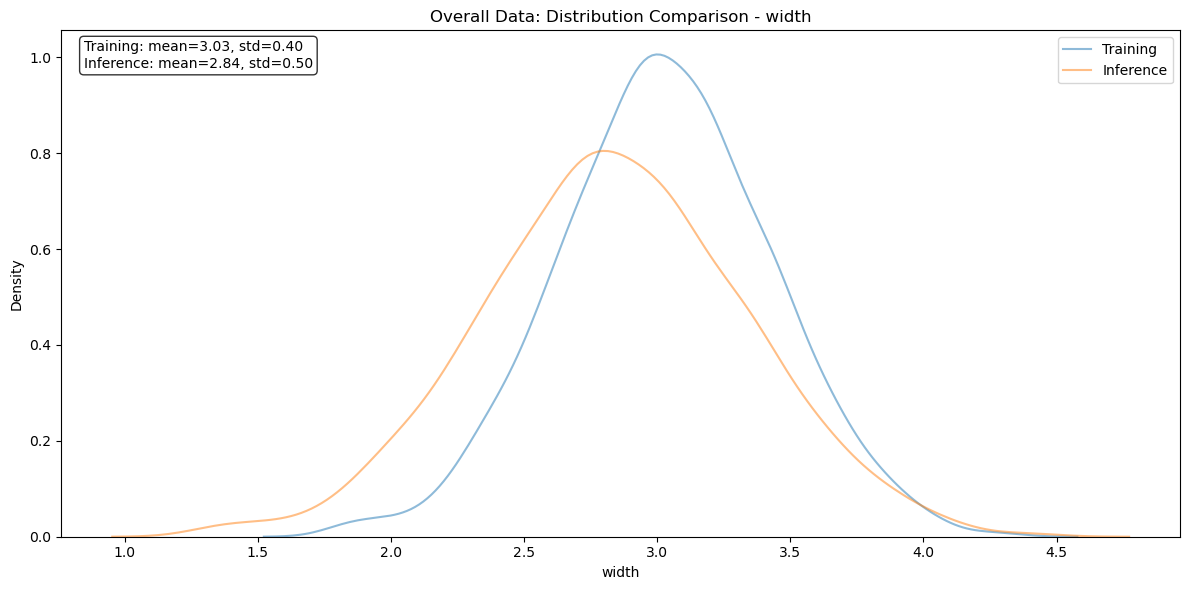

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


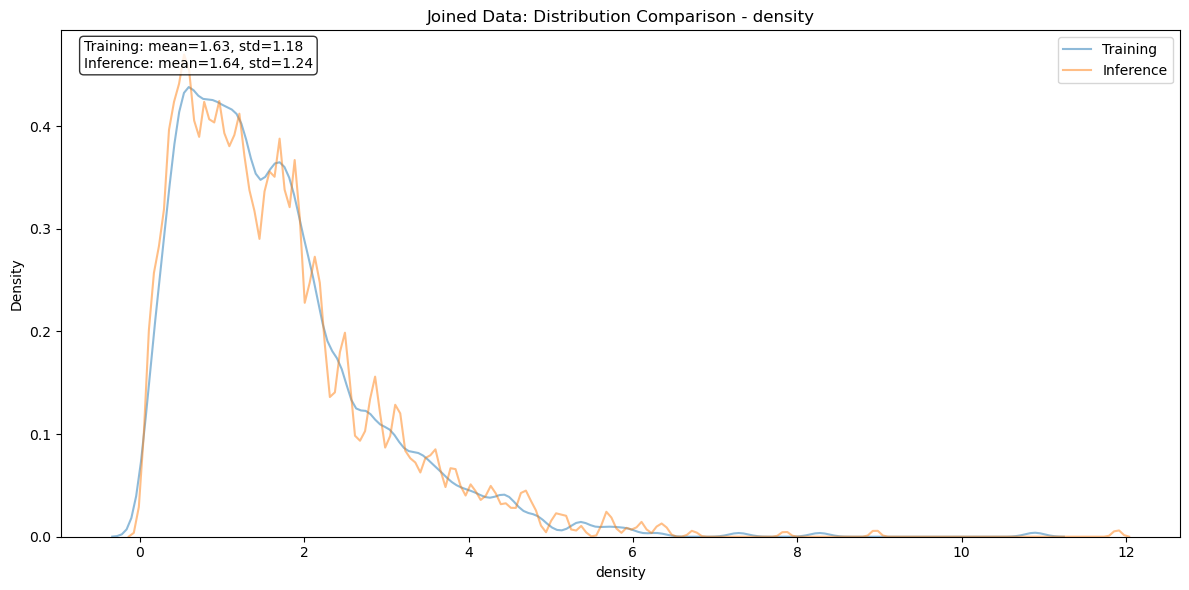

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


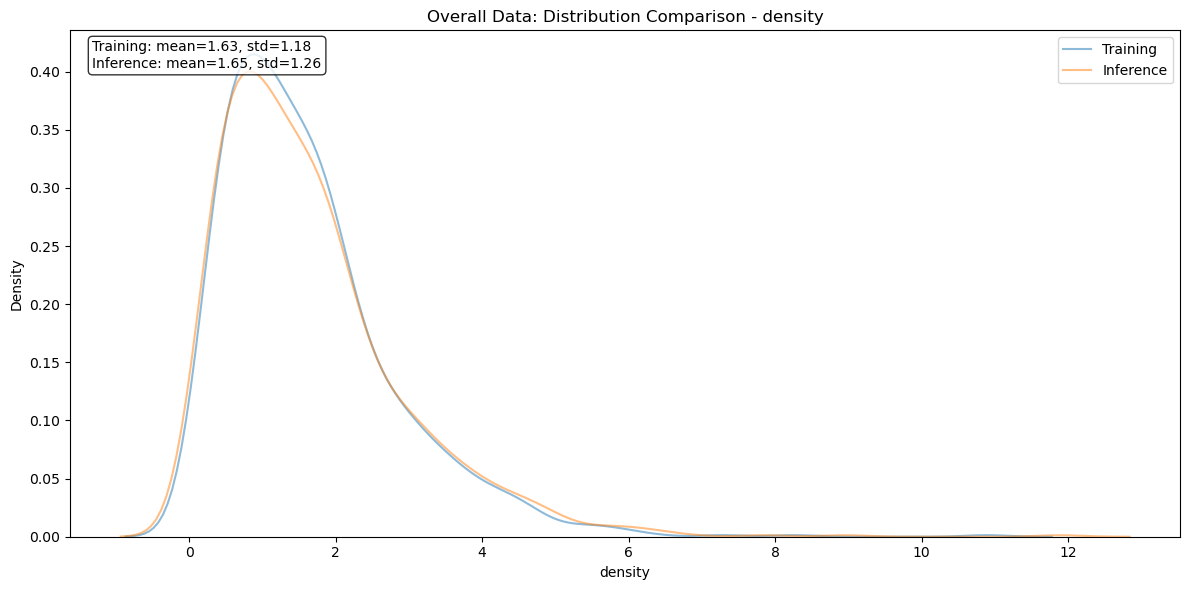

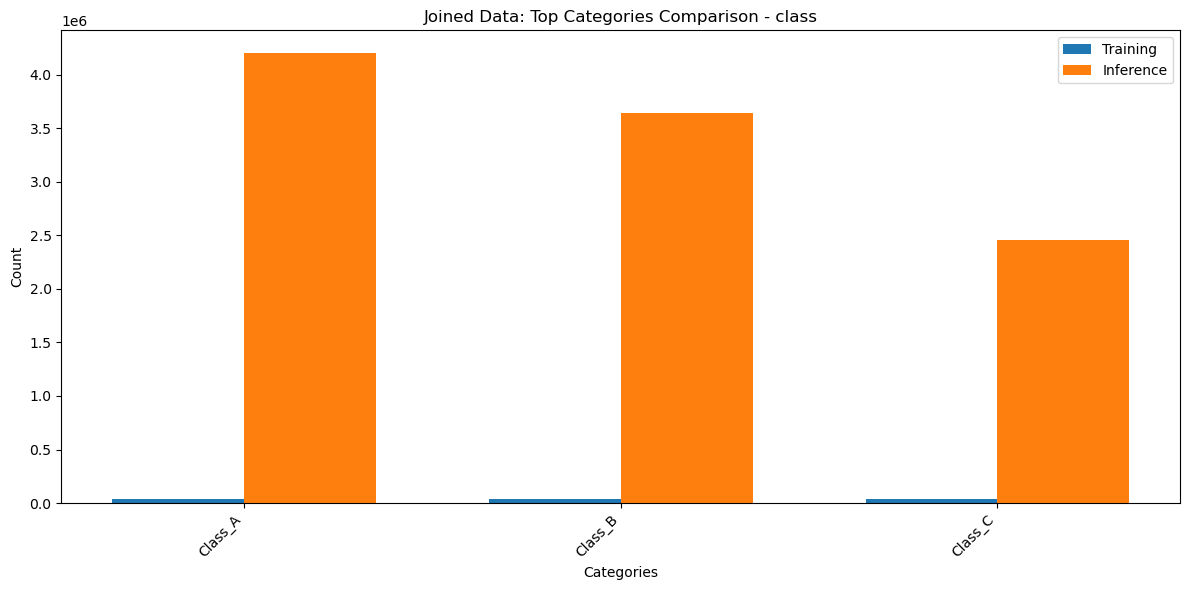

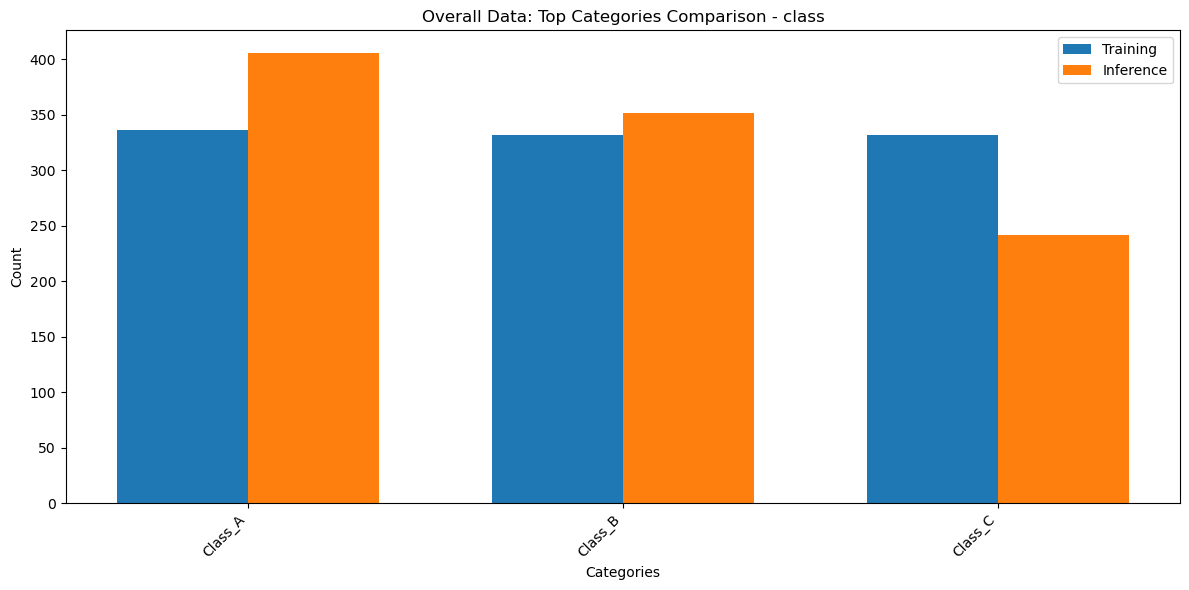

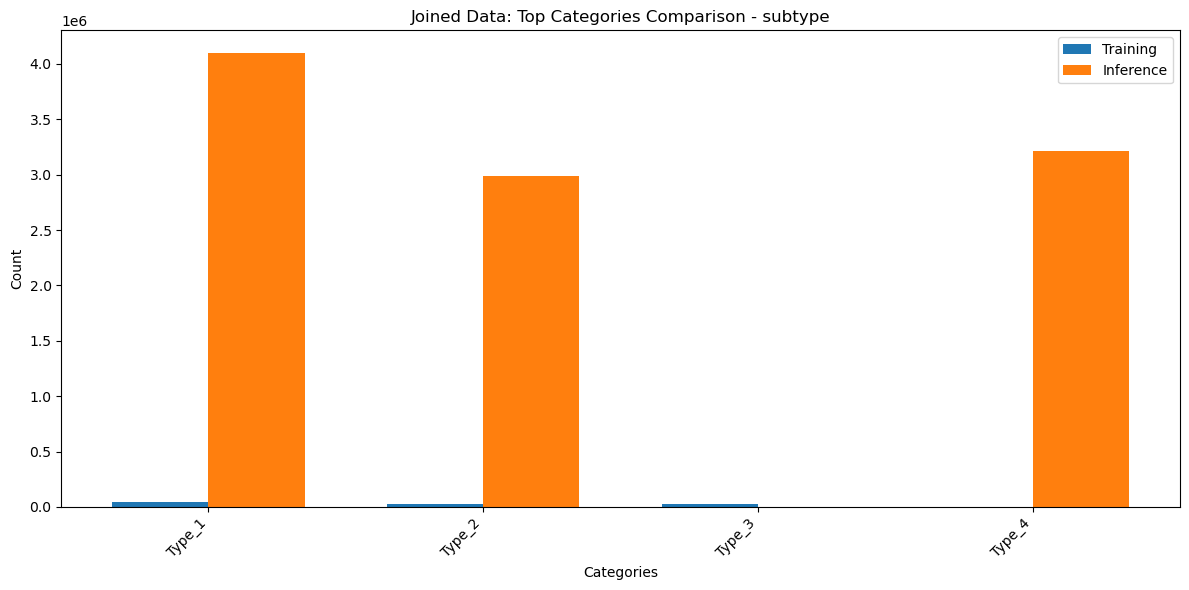

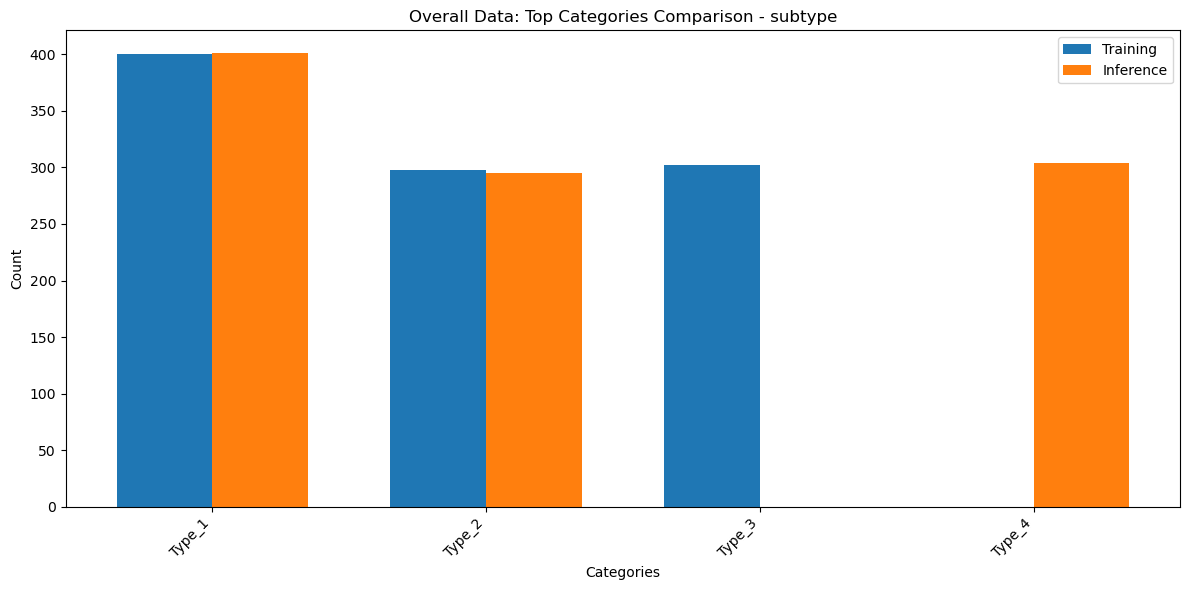

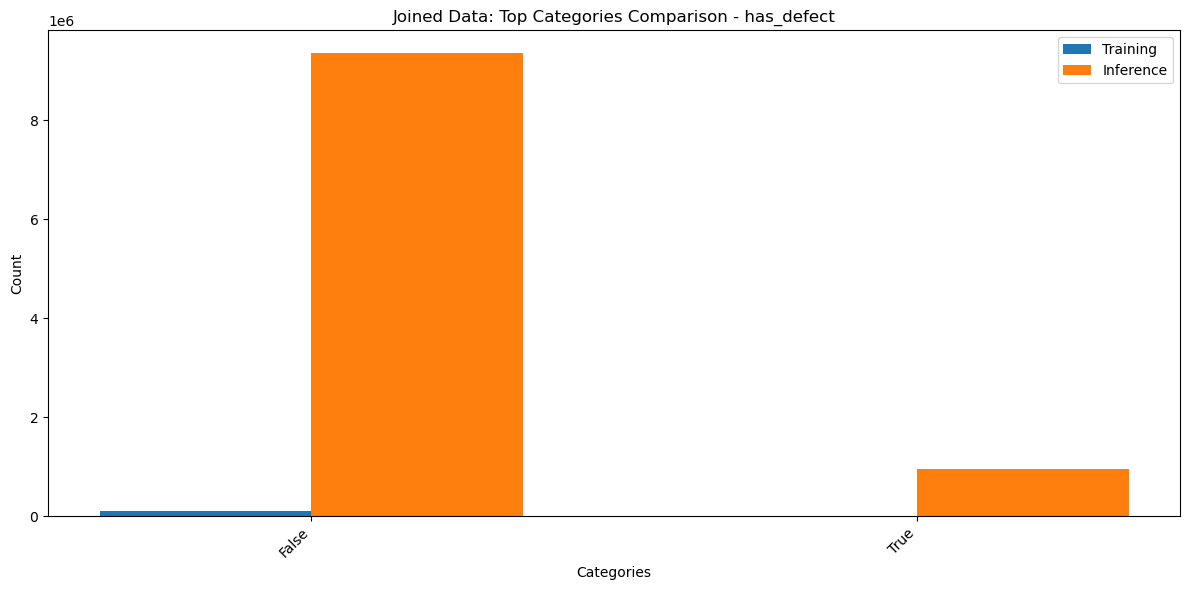

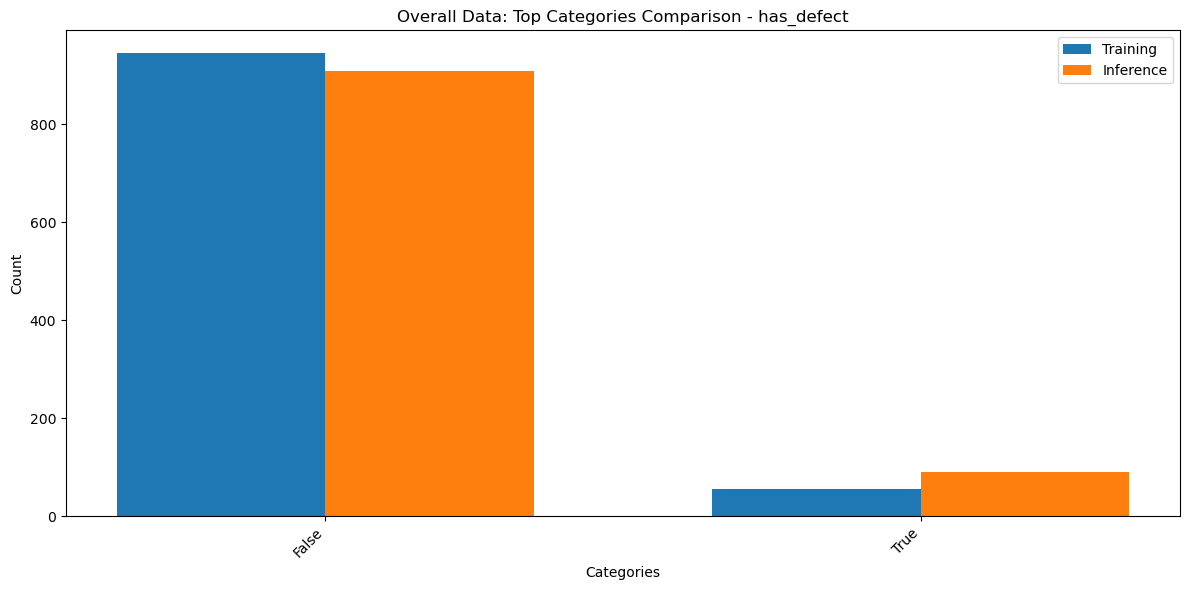


=== Training Data Sample ===
shape: (5, 8)
┌───────────┬──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬────────────┐
│ sample_id ┆ batch_id ┆ length   ┆ width    ┆ density  ┆ class   ┆ subtype ┆ has_defect │
│ ---       ┆ ---      ┆ ---      ┆ ---      ┆ ---      ┆ ---     ┆ ---     ┆ ---        │
│ i64       ┆ i64      ┆ f64      ┆ f64      ┆ f64      ┆ str     ┆ str     ┆ bool       │
╞═══════════╪══════════╪══════════╪══════════╪══════════╪═════════╪═════════╪════════════╡
│ 0         ┆ 6        ┆ 6.197371 ┆ 3.559742 ┆ 0.750512 ┆ Class_B ┆ Type_3  ┆ false      │
│ 1         ┆ 7        ┆ 5.689389 ┆ 3.369853 ┆ 1.189575 ┆ Class_C ┆ Type_3  ┆ false      │
│ 2         ┆ 1        ┆ 6.318151 ┆ 3.023852 ┆ 0.177984 ┆ Class_B ┆ Type_3  ┆ false      │
│ 3         ┆ 9        ┆ 7.018424 ┆ 2.741225 ┆ 1.565977 ┆ Class_B ┆ Type_2  ┆ true       │
│ 4         ┆ 8        ┆ 5.612677 ┆ 3.279289 ┆ 2.13667  ┆ Class_A ┆ Type_3  ┆ false      │
└───────────┴──────────┴──────────┴──────────┴

In [4]:
run_example(1000)